# Проект по статистическому анализу 

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

Основная цель проекта:  
Выяснить являются ли пользователи с платной подпиской более выгодные, с точки зрения выручки, для компании

План работы.  
1. Краткое ознакомление с данными
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение данных
5. Подсчёт выручки
6. Проверка гипотез
7. Распределения

Описание данных.  
1. Пользователи - users_go.csv
    1. user_id	- уникальный идентификатор пользователя
    2. name -	имя пользователя
    3. age - возраст
    4. city - город
    5. subscription_type - тип подписки (free, ultra)
2. Поездки — rides_go.csv
    1. user_id - уникальный идентификатор пользователя
    2. distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
    3. duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
    4. date - дата совершения поездки
3. Подписки - subscriptions_go.csv
    1. subscription_type - тип подписки
    2. minute_price	- стоимость одной минуты поездки по данной подписке
    3. start_ride_price	- стоимость начала поездки
    4. subscription_fee - стоимость ежемесячного платежа

In [1]:
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

#### Шаг 1. Загрузка данных

In [2]:
pd.set_option('display.max_columns', None)
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Из предварительного просмотра на данные самое важное, что можем отметить - это неправильный тип данных у стобца date датафрейма rides. Исправим это в предообработке вместе с избавлением от дубликатов и заполнением пустых значений.

#### Шаг 2. Предобработка данных

In [9]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [10]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

Пропущенных значений нет. Замечательно.

In [11]:
users.duplicated().sum()

31

In [12]:
users = users.drop_duplicates()
users.duplicated().sum()

0

In [13]:
rides.duplicated().sum()

0

Дубликаты в датафрейме users убраны!

In [14]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [15]:
rides['month'] = rides['date'].dt.month
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


Предобработка завершена. Пропущенных значений не нашлось. Дубликаты обработаны. Дата приведена к правильному типу данных. Новый столбец с номером месяца поездки создан.

#### Шаг 3. Исследовательский анализ данных

In [16]:
users['city'].describe()

count          1534
unique            8
top       Пятигорск
freq            219
Name: city, dtype: object

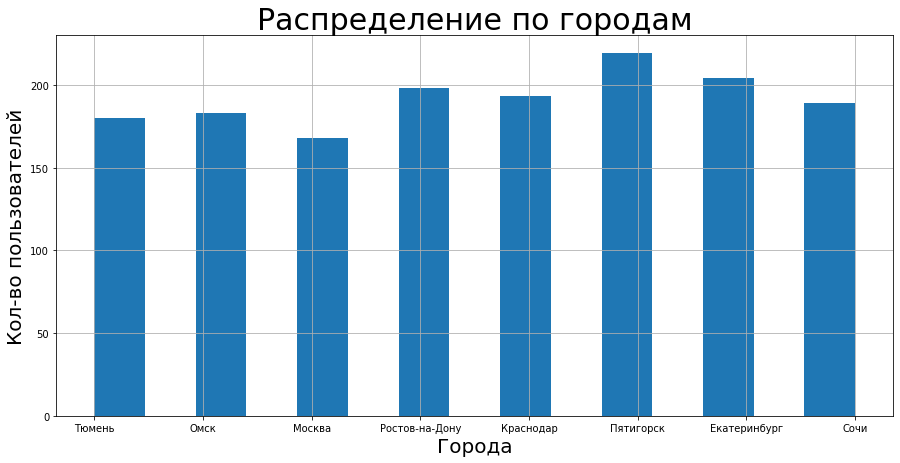

In [17]:
users['city'].hist(bins=15, figsize=(15,7));
plt.rcParams['font.size'] = '10'
plt.title('Распределение по городам', fontsize=30);
plt.xlabel('Города', fontsize=20);
plt.ylabel('Кол-во пользователей', fontsize=20);

Примерно равное распределение клиентов по городам. Как ни странно, меньше всего клиентов в Москве, больше всего в Пятигорске.

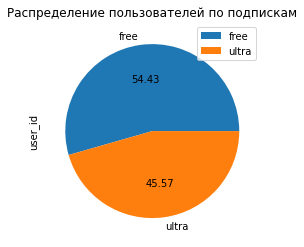

In [18]:
users.groupby(['subscription_type']).count().plot(kind='pie', autopct='%.2f', y='user_id');
plt.title('Распределение пользователей по подпискам');

Больше пользователей без платной подписки.

In [19]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

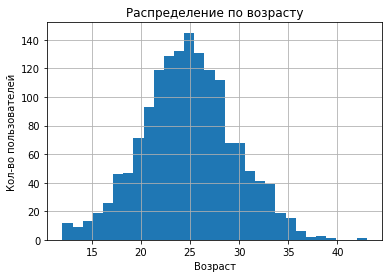

In [20]:
users['age'].hist(bins=30);
plt.title('Распределение по возрасту');
plt.xlabel('Возраст');
plt.ylabel('Кол-во пользователей');

Самому старому пользователю 43 года, самому молодому - 12. Средний возраст пользователей 24,9 лет, медианный - 25.

In [21]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

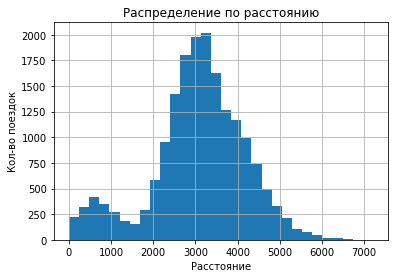

In [22]:
rides['distance'].hist(bins=30);
plt.title('Распределение по расстоянию');
plt.xlabel('Расстояние');
plt.ylabel('Кол-во поездок');

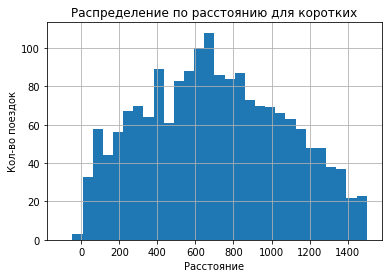

In [23]:
rides['distance'].hist(bins=30, range=(-100, 1500));
plt.title('Распределение по расстоянию для коротких');
plt.xlabel('Расстояние');
plt.ylabel('Кол-во поездок');

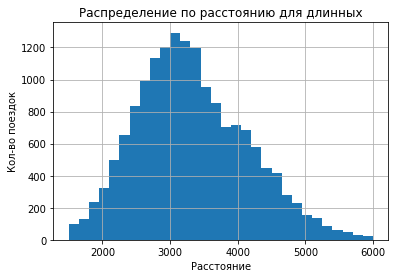

In [24]:
rides['distance'].hist(bins=30, range=(1500, 6000));
plt.title('Распределение по расстоянию для длинных');
plt.xlabel('Расстояние');
plt.ylabel('Кол-во поездок');

Максимальная дистанция поездки составила 7211 метров, минимальная чуть меньше метра(0,86 метра). Средняя дистанция поездки 3070 метров, медиана - 3133 метра.

In [25]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

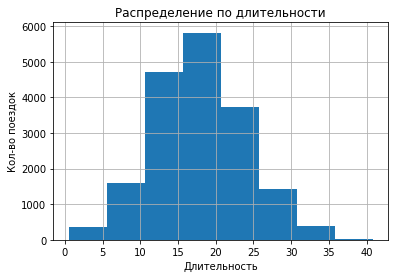

In [26]:
rides['duration'].hist(bins=8);
plt.title('Распределение по длительности');
plt.xlabel('Длительность');
plt.ylabel('Кол-во поездок');

Максимальная длительность поездки - почти 41 минута, минимальная - 30 секунд. Средняя длительность 17.81 минут, медианная - 17.7.

Общий вывод по исследовательскому анализу.  
1. По городам примерно равное распределение, однако можем выделить пятигорск, с наибольшим кол-вом пользователей(219).
2. По распределению пользователей по подпискам: незначительно больше пользователей без подписики
3. По возрасту: самому старому пользователю 43 года, самому молодому - 12. Средний возраст пользователей 24,9 лет, медианный - 25 
4. По расстоянию: максимальная дистанция поездки составила 7211 метров, минимальная чуть меньше метра(0,86 метра). Средняя дистанция поездки 3070 метров, медиана - 3133 метра.
5. По длительности: максимальная длительность поездки - почти 41 минута, минимальная - 30 секунд. Средняя длительность 17.81 минут, медианная - 17.7.

#### Шаг 4. Объединение данных

In [27]:
df = users.merge(rides, on=['user_id'], how='outer')
df = df.merge(subscriptions, on=['subscription_type'], how='outer')
df.head(30)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [29]:
df.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропусков в нашем датафрейме нет! Размерность - 18067 строк.

Таблицы объеденины.

In [30]:
df_free = df.query('subscription_type == "free"')
df_free.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
6505,700,Айдар,22,Омск,free,4342.002254,22.368009,2021-02-23,2,8,50,0
6506,700,Айдар,22,Омск,free,3798.334905,18.243756,2021-03-03,3,8,50,0
6507,700,Айдар,22,Омск,free,2984.551206,15.424899,2021-04-09,4,8,50,0
6508,700,Айдар,22,Омск,free,3360.107141,16.765497,2021-06-12,6,8,50,0
6509,700,Айдар,22,Омск,free,2567.543847,11.312160,2021-06-23,6,8,50,0


In [31]:
df_ultra = df.query('subscription_type == "ultra"')
df_ultra.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


Датафреймы по типу подписки пользователей созданы.

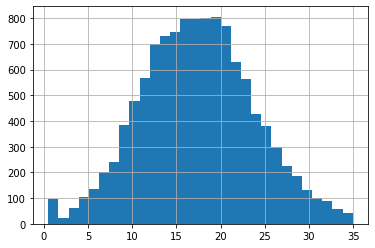

In [32]:
df_free['duration'].hist(bins=30);

In [33]:
df_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

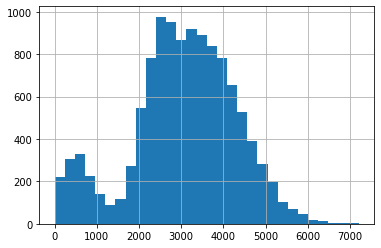

In [34]:
df_free['distance'].hist(bins=30);

In [35]:
df_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

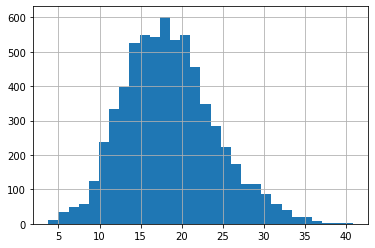

In [36]:
df_ultra['duration'].hist(bins=30);

In [37]:
df_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

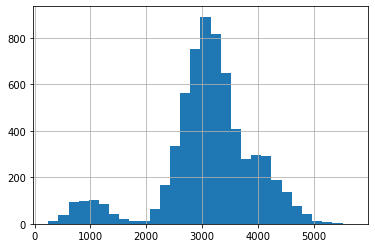

In [38]:
df_ultra['distance'].hist(bins=30);

In [39]:
df_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Cреднее время поездки у пользователей без платной подписки 17.4 минут, медианное - 17.3. У платных подписчиков среднее 18.5, медианное 18.2. Средняя дистанции у бесплатных - 3045 метров, медианная - 3114. У платных средняя 3114, медианная 3148.  Разница между ними не так и велика!

Общий вывод по объединению данных.  
1. Создан общий датафрейм df состоящий из 3 изначальных датафреймов users, rides, subscriptions.  
2. На его основе создано 2 дата фрейма для платных и бесплатных пользователей.  
3. Для двух этих датафреймов построены гистограммы и вычислены средниеи медианные значиние, а именно:  
Cреднее время поездки у пользователей без платной подписки 17.4 минут, медианное - 17.3. У платных подписчиков среднее 18.5, медианное 18.2. Средняя дистанции у бесплатных - 3045 метров, медианная - 3114. У платных средняя 3114, медианная 3148.

#### Шаг 5. Подсчёт выручки

In [40]:
df['duration'] = np.ceil(df['duration'])
#Округлим все минуты поездок в большую сторону, для корректных рассчетов

In [41]:
duration_per_month = df.groupby(['user_id', 'month']).agg(duration_per_month=('duration', 'sum'))
duration_per_month.head(10)

duration_per_month
user_id month                    
1       1                    42.0
        4                     7.0
        8                    46.0
        10                   32.0
        11                   56.0
        12                   28.0
2       3                    63.0
        4                    40.0
        6                    14.0
        7                    48.0

In [42]:
distance_per_month = df.groupby(['user_id', 'month']).agg(distance_per_month=('distance', 'sum'))
distance_per_month.head(10)

distance_per_month
user_id month                    
1       1             7027.511294
        4              754.159807
        8             6723.470560
        10            5809.911100
        11            7003.499363
        12            6751.629942
2       3            10187.723006
        4             6164.381824
        6             3255.338202
        7             6780.722964

In [43]:
count_per_month = df.groupby(['user_id', 'month']).agg(count_per_month=('distance', 'count'))
count_per_month.head(10)

count_per_month
user_id month                 
1       1                    2
        4                    1
        8                    2
        10                   2
        11                   3
        12                   2
2       3                    3
        4                    2
        6                    1
        7                    2

In [44]:
df_agg = count_per_month.merge(distance_per_month, how='outer', on=['user_id', 'month'])\
    .merge(duration_per_month, how='outer', on=['user_id', 'month'])\
    .reset_index()\
    .merge(users, how='outer', on=['user_id'])\
    .merge(subscriptions, on=['subscription_type'])
df_agg.head(20)

,user_id,month,count_per_month,distance_per_month,duration_per_month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.511294,42.0,Кира,22,Тюмень,ultra,6,0,199
1,1,4,1,754.159807,7.0,Кира,22,Тюмень,ultra,6,0,199
2,1,8,2,6723.470560,46.0,Кира,22,Тюмень,ultra,6,0,199
3,1,10,2,5809.911100,32.0,Кира,22,Тюмень,ultra,6,0,199
4,1,11,3,7003.499363,56.0,Кира,22,Тюмень,ultra,6,0,199
5,1,12,2,6751.629942,28.0,Кира,22,Тюмень,ultra,6,0,199
6,2,3,3,10187.723006,63.0,Станислав,31,Омск,ultra,6,0,199
7,2,4,2,6164.381824,40.0,Станислав,31,Омск,ultra,6,0,199
8,2,6,1,3255.338202,14.0,Станислав,31,Омск,ultra,6,0,199
9,2,7,2,6780.722964,48.0,Станислав,31,Омск,ultra,6,0,199


In [45]:
df_agg['earnings_per_month'] = df_agg['start_ride_price'] * df_agg['count_per_month'] +\
    df_agg['minute_price'] * df_agg['duration_per_month'] + df_agg['subscription_fee']
df_agg.head(20)

,user_id,month,count_per_month,distance_per_month,duration_per_month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,earnings_per_month
0,1,1,2,7027.511294,42.0,Кира,22,Тюмень,ultra,6,0,199,451.0
1,1,4,1,754.159807,7.0,Кира,22,Тюмень,ultra,6,0,199,241.0
2,1,8,2,6723.470560,46.0,Кира,22,Тюмень,ultra,6,0,199,475.0
3,1,10,2,5809.911100,32.0,Кира,22,Тюмень,ultra,6,0,199,391.0
4,1,11,3,7003.499363,56.0,Кира,22,Тюмень,ultra,6,0,199,535.0
5,1,12,2,6751.629942,28.0,Кира,22,Тюмень,ultra,6,0,199,367.0
6,2,3,3,10187.723006,63.0,Станислав,31,Омск,ultra,6,0,199,577.0
7,2,4,2,6164.381824,40.0,Станислав,31,Омск,ultra,6,0,199,439.0
8,2,6,1,3255.338202,14.0,Станислав,31,Омск,ultra,6,0,199,283.0
9,2,7,2,6780.722964,48.0,Станислав,31,Омск,ultra,6,0,199,487.0


Дата фрейм из агрегированных данных создан, выручка за месяц посчитана.

#### Шаг 6. Проверка гипотез

Установим уровень статистической значимости 0.05

In [46]:
alpha = .05

Проверяем гипотезу о времени поездки пользователей.  
H0: Пользователи с подпиской тратят столько же времени на поездки, как и пользователи без подписки (=)  
H1: Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки (>)

In [47]:
ultras_duration = df_ultra['duration']
frees_duration = df_free['duration']

result_duration = st.ttest_ind(ultras_duration, frees_duration, alternative='greater')

result_duration.pvalue

1.2804098316645618e-34

In [48]:
if result_duration.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


In [49]:
print('Среднее время поездки пользователей с подпиской:', ultras_duration.mean())
print('Среднее время поездки пользователей без подпиской:', frees_duration.mean())

Среднее время поездки пользователей с подпиской: 18.54198516280583
Среднее время поездки пользователей без подпиской: 17.39090929866399


Отвергаем гипотезу о том, что пользователи с подпиской тратят больше времени на поездки

Проверим гипотезу о том, что среднее расстояния поездки пользователей с подпиской не первышает 3130 метров.  
H0: Среднее расстояние, которое преодолевают пользователи с подпиской равна оптимальным 3130 метрам.  
H1: Среднее расстояние, которое преодолевают пользователи с подпиской превышает оптимальные 3130 метров.  

In [50]:
avg_distance_value = 3130

ultra_distance = df_ultra['distance']

result_distance = st.ttest_1samp(ultra_distance, avg_distance_value, alternative = 'greater')

result_distance.pvalue

0.9195368847849785

In [51]:
if (result_distance.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Не отвергаем нулевую гипотезу


In [52]:
print('Средняя дальность поездки пользователей с подпиской:', ultra_distance.mean())

Средняя дальность поездки пользователей с подпиской: 3115.4453880370247


Не отвергаем данную гипотезу, после проверки. Подвердить мы ее так же не можем, однако можем сказать, что велика вероятность того, что средняя поездка пользователей с подпиской не превышает 3130 метров

Проверяем гипотезу о том, что средняя помесячная выручка пользователей с подпиской будет больше, чем у пользователей без подписки  
H0: средняя помесячная выручка пользователей с подпиской такая же, как и у пользователей без подписки  
H1: средняя помесячная выручка пользователей с подпиской больше, чем пользователей без подписки

In [53]:
ultras_earnings_per_month = df_agg.query('subscription_type == "ultra"')['earnings_per_month']
frees_earnings_per_month = df_agg.query('subscription_type == "free"')['earnings_per_month']

result_earnings = st.ttest_ind(ultras_earnings_per_month, frees_earnings_per_month, alternative='greater')

result_earnings.pvalue

1.8850394384715216e-31

In [54]:
ultras_earnings_per_month

0       451.0
1       241.0
2       475.0
3       391.0
4       535.0
        ...  
4528    301.0
4529    469.0
4530    385.0
4531    295.0
4532    355.0
Name: earnings_per_month, Length: 4533, dtype: float64

In [55]:
if (result_earnings.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Отвергаем нулевую гипотезу


In [56]:
print('Средняя ежемесячная выручка с пользователей с подпиской:', ultras_earnings_per_month.mean())
print('Средняя ежемесячная выручка с пользователей без подпиской:', frees_earnings_per_month.mean())

Средняя ежемесячная выручка с пользователей с подпиской: 362.7921906022502
Средняя ежемесячная выручка с пользователей без подпиской: 328.6413651073845


Можем смело опровергнуть данную гипотезу. Помесячная выручка с пользователей без подписки может превышать выручку от пользователей с подпиской.

6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

t-тест scipy.stats.ttest_rel()

#### Шаг 7. Распределения

In [57]:
# задаём параметры биномиального распределения
n = 1169
p = 0.1
avg = 100

mu = n * p
sigma = sqrt(n * p * (1 - p))
 
distr = st.norm(mu, sigma)

result = distr.cdf(avg)
result

0.04971489312694162

Для нужно нам результата нужно разослать примерно 1169 промокодов

In [58]:
n1 = 1000000
p1 = 0.4
avg1 = 399500

mu1 = n1 * p1
sigma1 = sqrt(n1 * p1 * (1 - p1))

distr1 = st.norm(mu1, sigma1) 

result1 = distr1.cdf(avg1)
result1

0.15371708296369768

Вероятность того, что уведомление откроют не более 399500 пользователей составляет 15%.

**Общий вывод**  
1. На этапе предобработки были удалены явные дубликаты, и изменен тип данных у даты датафрейма rides, так же был добавлен столбец с номером месяца.
2. Были исследованы следующие данные:
    1. Распределение пользователей по городам, так с наибольшим количеством пользователей оказался Пятигорск, а с наименьшим - Москва
    2. Распределение пользователей по подпискам. Выяснилось, что в целом количество пользователей с подпиской и без примерно равное(доля от общего 45.47% и 54.43% соответственно), однако без подписки пользователей все же больше.
    3. Распределение по возрасту. Самому старому пользователю 43 года, самому молодому - 12. Средний возраст пользователей 24,9 лет, медианный - 25
    4. Распределение по расстоянию. Максимальная дистанция поездки составила 7211 метров, минимальная чуть меньше метра(0,86 метра). Средняя дистанция поездки 3070 метров, медиана - 3133 метра.
    5. Распределение по длительности. Максимальная длительность поездки - почти 41 минута, минимальная - 30 секунд. Средняя длительность 17.81 минут, медианная - 17.7
3. Далее был создан датафрейм df в которой вошли все наших исходных датафрейма(users, rides, subscriptions). И на его основе были созданы датафреймы с пользователями без подписки(df_free) и пользователями с подпиской(df_ultra).
4. На основе датафреймов df_free и df_ultra были изучены следующие показатели для платных пользователей и бесплатных(условно бесплатных):
    1. Cреднее время поездки у пользователей без платной подписки 17.4 минут, медианное - 17.3. У платных подписчиков среднее 18.5, медианное 18.2. 
    2. Средняя дистанция у бесплатных - 3045 метров, медианная - 3114. У платных средняя 3114, медианная 3148.
5. Была создана таблица df_agg в которую основными столбцами вошли посчитанные данные для каждого пользователя по:
    1. Количетсву поездок в месяц
    2. Дистанции преодоленной за месяц
    3. Времени поездок за месяц.
6. Были выдвинуты и проверены несколько гипотез:
    1. H0: Пользователи с подпиской тратят столько же времени на поездки, как и пользователи без подписки (=)  
       H1: Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки (>)  
       Нулевая гипотеза была отвергнута.
    2. H0: Среднее расстояние, которое преодолевают пользователи с подпиской равна оптимальным 3130 метрам.  
       H1: Среднее расстояние, которое преодолевают пользователи с подпиской превышает оптимальные 3130 метров.  
       Нулевую гипотезу не удалось опровернуть, значит вероятность того, что она правильная повысилась
    3. H0: средняя помесячная выручка пользователей с подпиской такая же, как и у пользователей без подписки  
       H1: средняя помесячная выручка пользователей с подпиской больше, чем пользователей без подписки  
       Нулевая гипотеза была отвергнута.  
       
В целом по результатам нашего исследования можно сказать, что пользователи без подписки важны не меньше, чем пользователи с подпиской, так как они приносят примерно такую же(сопостовимую) прибыль, как и пользователи с подпиской.